In [1]:
!pwd

/Users/eugene/Personal_Projects/Real_ML_Project/kitchenware_classification_efficientnet_model/research


In [2]:
! chmod 600 /Users/eugene/Personal_Projects/Real_ML_Project/kitchenware_classification_efficientnet_model/.kaggle/kaggle.json

In [17]:
# ! ~/.local/bin/kaggle datasets download -d agrigorev/kitchenware-extra-images 
! ~/.local/bin/kaggle competitions download -c kitchenware-classification

100%|██████████████████████████████████████| 1.63G/1.63G [08:07<00:00, 3.89MB/s]
100%|██████████████████████████████████████| 1.63G/1.63G [08:07<00:00, 3.59MB/s]


! mkdir  ./kitchenware-data
! chmod +w ./kitchenware-data
! unzip ./kitchenware-classification.zip -d ./kitchenware-data

In [19]:
! rm -R ./kitchenware-classification.zip

# Import Libraries

In [89]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import normalize

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')


# Load Data

In [53]:
train_data = pd.read_csv('./kitchenware-data/train.csv', dtype={'Id': str})
test_data = pd.read_csv('./kitchenware-data/test.csv', dtype={'Id': str})
# data = pd.read_csv('train.csv', dtype={'Id': str})
print(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      5559 non-null   object
 1   label   5559 non-null   object
dtypes: object(2)
memory usage: 87.0+ KB
None


,Id,label
0,0560,glass
1,4675,cup
2,0875,glass
3,4436,spoon
4,8265,plate


In [54]:
# create the image data column
train_data['image'] =  "./kitchenware-data/images/" + train_data['Id'] + ".jpg"
test_data['image'] =  "./kitchenware-data/images/" + test_data['Id'] + ".jpg"
train_data.head()

,Id,label,image
0,0560,glass,./kitchenware-data/images/0560.jpg
1,4675,cup,./kitchenware-data/images/4675.jpg
2,0875,glass,./kitchenware-data/images/0875.jpg
3,4436,spoon,./kitchenware-data/images/4436.jpg
4,8265,plate,./kitchenware-data/images/8265.jpg


In [58]:
# output the first few  records of the test data as well
test_data.head()

,Id,image
0,0678,./kitchenware-data/images/0678.jpg
1,3962,./kitchenware-data/images/3962.jpg
2,9271,./kitchenware-data/images/9271.jpg
3,5133,./kitchenware-data/images/5133.jpg
4,8842,./kitchenware-data/images/8842.jpg


In [59]:
train_data['image'][0]

'./kitchenware-data/images/0560.jpg'

# EDA

In [60]:
# check for data imbalance
train_data['label'].value_counts()

label
plate    1227
cup      1135
spoon     989
knife     909
glass     742
fork      557
Name: count, dtype: int64

In [61]:
# retrieve one single image
def load_single_img(df, num):
    with Image.open(df['image'][num]) as im:
        im.rotate(45).show()
        
load_single_img(train_data, 0)


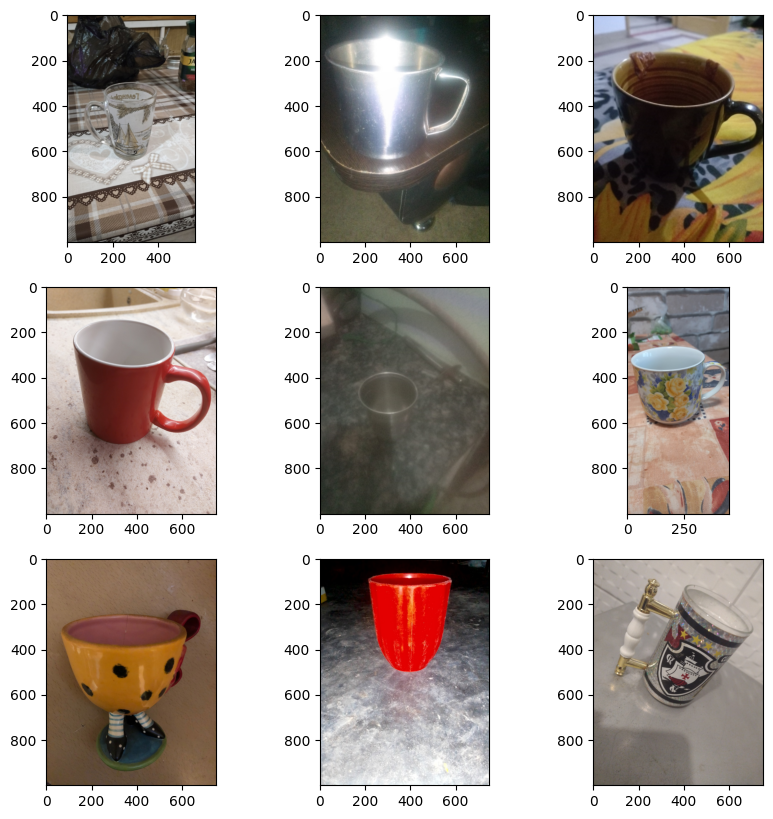

In [62]:
# retrieve several images
# let's get different varieties of a particular class of object, say plates
def plot_imgs_of_a_single_class(df,class_name ):
    nb_rows = 3
    nb_cols = 3
    img_no = 0

    fig, axs =  plt.subplots(nb_rows, nb_cols, figsize=(10,10))

    for i in range(nb_rows):
        for j in range(nb_cols):
            tmp = df[df['label'] == class_name]
            tmp.reset_index(inplace=True, drop=True)
            with Image.open(tmp['image'][img_no]) as im:
                    axs[i,j].imshow(im)
                    img_no+=1
                    
                    
plot_imgs_of_a_single_class(train_data, 'cup')

In [140]:
# obtain the class dictionary
class_labels = train_data['label'].unique()
print(class_labels)
print()
le = LabelEncoder()
le.fit(class_labels)
class_num = le.transform(class_labels)
print(class_num)
class_dict = dict(zip(class_labels, class_num))
class_dict


['glass' 'cup' 'spoon' 'plate' 'knife' 'fork']

[2 0 5 4 3 1]


{'glass': 2, 'cup': 0, 'spoon': 5, 'plate': 4, 'knife': 3, 'fork': 1}

# Train test split

In [77]:

x_train, x_val, y_train, y_val = train_test_split(
    train_data, train_data['label'], test_size=0.2, random_state=42)

In [81]:
x_train.reset_index(drop=True, inplace=True)
x_val.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)


In [83]:
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(4447, 3) (1112, 3) (4447,) (1112,)


In [84]:
print(y_train.unique())
print(y_val.unique())

['spoon' 'knife' 'glass' 'cup' 'plate' 'fork']
['plate' 'knife' 'spoon' 'cup' 'fork' 'glass']


In [85]:
x_train.drop(columns=['Id'], inplace=True)
x_val.drop(columns=['Id'], inplace=True)
x_train.head()

,label,image
0,spoon,./kitchenware-data/images/8242.jpg
1,knife,./kitchenware-data/images/0181.jpg
2,spoon,./kitchenware-data/images/4897.jpg
3,spoon,./kitchenware-data/images/7430.jpg
4,glass,./kitchenware-data/images/4286.jpg


# Image Resizing and Dataset creation 

In [90]:
batch_size = 32
image_shape = (150,150)

train_gen = ImageDataGenerator(preprocessing_function= preprocess_input)
val_gen = ImageDataGenerator(preprocessing_function= preprocess_input)

train_ds = train_gen.flow_from_dataframe(
    x_train,
    target_size = image_shape,
    batch_size = batch_size,
    x_col = 'image',
    y_col = 'label',
    class_mode = 'categorical',
    shuffle = True,
    seed = 42
)

Found 4447 validated image filenames belonging to 6 classes.


In [91]:
val_ds = val_gen.flow_from_dataframe(
    x_val,
    target_size = image_shape,
    batch_size = batch_size,
    x_col = 'image',
    y_col = 'label',
    class_mode = 'categorical',
    shuffle = False,
    seed = 42
)

Found 1112 validated image filenames belonging to 6 classes.


# Model Development

In [95]:
def make_model(
        input_size, 
        learning_rate, 
        size_inner,
        droprate):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [96]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [97]:
input_size = 150
learning_rate = 0.0005
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=10, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.7236 - loss: 0.7878 - val_accuracy: 0.8849 - val_loss: 0.3104
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.8940 - loss: 0.2918 - val_accuracy: 0.8849 - val_loss: 0.3041
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9271 - loss: 0.2068 - val_accuracy: 0.8975 - val_loss: 0.2797
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 137s 969ms/step - accuracy: 0.9488 - loss: 0.1579 - val_accuracy: 0.8948 - val_loss: 0.2979
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 136s 964ms/step - accuracy: 0.9543 - loss: 0.1427 - val_accuracy: 0.8930 - val_loss: 0.3105
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9606 - loss: 0.1156 - val_accuracy: 0.8993 - val_loss: 0.2887
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9789 - loss: 0.0819 - val_accuracy: 0.8966 - val_loss: 0.2964
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9812 - loss: 0.0748 - va

# Model Evaluation and Prediction

In [98]:
model = keras.models.load_model('xception_v4_1_08_0.905.keras')

In [100]:
test_data.drop(['Id'], axis=1, inplace=True)
test_data.head()

,image
0,./kitchenware-data/images/0678.jpg
1,./kitchenware-data/images/3962.jpg
2,./kitchenware-data/images/9271.jpg
3,./kitchenware-data/images/5133.jpg
4,./kitchenware-data/images/8842.jpg


In [111]:
# images_path = './research/kitchenware-data/images'
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)


test_ds = test_gen.flow_from_dataframe(
    dataframe=test_data,
    x_col="image",
    target_size=image_shape,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
)

Found 3808 validated image filenames.


In [126]:
test_ds.filenames

['./kitchenware-data/images/0678.jpg',
 './kitchenware-data/images/3962.jpg',
 './kitchenware-data/images/9271.jpg',
 './kitchenware-data/images/5133.jpg',
 './kitchenware-data/images/8842.jpg',
 './kitchenware-data/images/8256.jpg',
 './kitchenware-data/images/4622.jpg',
 './kitchenware-data/images/2775.jpg',
 './kitchenware-data/images/5900.jpg',
 './kitchenware-data/images/6372.jpg',
 './kitchenware-data/images/0781.jpg',
 './kitchenware-data/images/4827.jpg',
 './kitchenware-data/images/6886.jpg',
 './kitchenware-data/images/7823.jpg',
 './kitchenware-data/images/1958.jpg',
 './kitchenware-data/images/0044.jpg',
 './kitchenware-data/images/2386.jpg',
 './kitchenware-data/images/1311.jpg',
 './kitchenware-data/images/7053.jpg',
 './kitchenware-data/images/9204.jpg',
 './kitchenware-data/images/8314.jpg',
 './kitchenware-data/images/0766.jpg',
 './kitchenware-data/images/9102.jpg',
 './kitchenware-data/images/5210.jpg',
 './kitchenware-data/images/3249.jpg',
 './kitchenware-data/imag

In [114]:
pred = model.predict(test_ds)

119/119 ━━━━━━━━━━━━━━━━━━━━ 94s 786ms/step


In [127]:
len(pred)

3808

In [135]:
pred[:5]

array([[-2.0225887 ,  1.2951419 , -0.8861128 ,  2.9414153 , -1.8758686 ,
         0.6165126 ],
       [-5.745753  ,  1.4714265 , -3.030762  ,  7.083352  , -4.8469634 ,
        -1.8857012 ],
       [-6.271905  ,  4.9625893 , -2.6307821 ,  8.416822  , -7.6895366 ,
        -1.2186333 ],
       [-1.2540979 , -3.0926027 , -2.3015785 , -1.172964  ,  9.477345  ,
        -5.5850058 ],
       [-3.934771  ,  5.7253504 , -1.7826018 ,  0.81123114, -8.131382  ,
         4.0591984 ]], dtype=float32)

In [162]:
classes = pred.argmax(axis=1)
class_list = list(classes)
print(classes)
print(class_list)

[3 3 3 ... 5 5 5]
[3, 3, 3, 4, 1, 1, 5, 1, 3, 0, 4, 2, 3, 4, 5, 0, 5, 0, 3, 0, 1, 5, 2, 4, 0, 0, 3, 5, 2, 3, 0, 0, 0, 0, 2, 4, 0, 4, 4, 4, 4, 2, 4, 4, 3, 5, 0, 0, 0, 5, 0, 0, 3, 0, 0, 4, 3, 2, 0, 4, 4, 3, 3, 1, 4, 5, 0, 5, 0, 1, 0, 3, 3, 2, 2, 0, 5, 5, 3, 3, 5, 2, 4, 0, 2, 3, 4, 2, 0, 3, 3, 5, 3, 5, 2, 2, 5, 1, 5, 4, 5, 4, 1, 0, 4, 1, 1, 0, 4, 5, 5, 4, 5, 4, 2, 3, 0, 0, 5, 4, 3, 4, 4, 3, 2, 4, 4, 1, 4, 2, 4, 0, 0, 0, 1, 5, 4, 0, 3, 1, 0, 4, 3, 1, 2, 5, 3, 1, 0, 5, 3, 0, 3, 1, 3, 3, 3, 3, 5, 0, 5, 3, 4, 3, 3, 2, 3, 2, 3, 4, 0, 2, 3, 4, 5, 3, 5, 2, 4, 4, 5, 2, 5, 0, 2, 3, 5, 0, 1, 5, 3, 0, 4, 5, 2, 5, 4, 2, 4, 3, 5, 0, 4, 0, 5, 2, 3, 3, 5, 4, 4, 2, 4, 3, 4, 1, 5, 5, 4, 4, 0, 4, 5, 0, 3, 4, 1, 0, 3, 2, 0, 2, 0, 2, 2, 0, 4, 4, 1, 3, 4, 3, 3, 2, 1, 2, 0, 4, 4, 0, 2, 3, 5, 2, 0, 4, 4, 4, 3, 1, 4, 4, 2, 4, 5, 5, 1, 5, 2, 5, 0, 4, 0, 5, 4, 4, 4, 0, 3, 1, 4, 3, 5, 4, 2, 3, 4, 1, 0, 4, 5, 3, 2, 0, 4, 4, 4, 1, 4, 3, 2, 3, 4, 5, 4, 3, 4, 0, 5, 0, 4, 0, 5, 4, 0, 3, 5, 3, 5, 5, 1, 4, 3, 4, 3, 5, 0, 

In [163]:
class_dict

{'glass': 2, 'cup': 0, 'spoon': 5, 'plate': 4, 'knife': 3, 'fork': 1}

In [181]:
result = {value:key for key, value in class_dict.items()}
result_class =  [result[i] for i in class_list]
result_class

['knife',
 'knife',
 'knife',
 'plate',
 'fork',
 'fork',
 'spoon',
 'fork',
 'knife',
 'cup',
 'plate',
 'glass',
 'knife',
 'plate',
 'spoon',
 'cup',
 'spoon',
 'cup',
 'knife',
 'cup',
 'fork',
 'spoon',
 'glass',
 'plate',
 'cup',
 'cup',
 'knife',
 'spoon',
 'glass',
 'knife',
 'cup',
 'cup',
 'cup',
 'cup',
 'glass',
 'plate',
 'cup',
 'plate',
 'plate',
 'plate',
 'plate',
 'glass',
 'plate',
 'plate',
 'knife',
 'spoon',
 'cup',
 'cup',
 'cup',
 'spoon',
 'cup',
 'cup',
 'knife',
 'cup',
 'cup',
 'plate',
 'knife',
 'glass',
 'cup',
 'plate',
 'plate',
 'knife',
 'knife',
 'fork',
 'plate',
 'spoon',
 'cup',
 'spoon',
 'cup',
 'fork',
 'cup',
 'knife',
 'knife',
 'glass',
 'glass',
 'cup',
 'spoon',
 'spoon',
 'knife',
 'knife',
 'spoon',
 'glass',
 'plate',
 'cup',
 'glass',
 'knife',
 'plate',
 'glass',
 'cup',
 'knife',
 'knife',
 'spoon',
 'knife',
 'spoon',
 'glass',
 'glass',
 'spoon',
 'fork',
 'spoon',
 'plate',
 'spoon',
 'plate',
 'fork',
 'cup',
 'plate',
 'fork',
 

<Figure size 640x480 with 0 Axes>

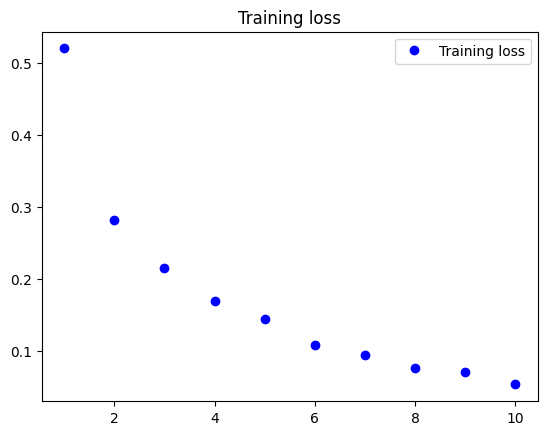

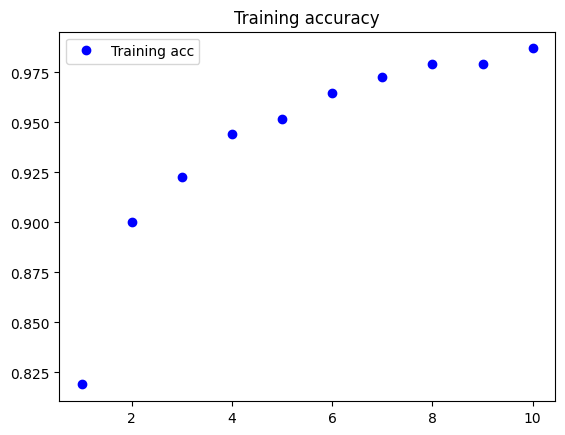

<Figure size 640x480 with 0 Axes>

In [165]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()